In [3]:
import os
os.chdir('../app')

In [4]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import re
import preprocessing.preglobal as pg
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
import cv2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient, UpdateMany, UpdateOne, InsertOne
import pandas as pd
from matplotlib import rc
import json

In [6]:
url='mongodb://192.168.0.94:27017/'
client = MongoClient(url)
tbl = client['global']['keynotes']
tbl2 = client['global']['timekeys']

In [7]:
folder = "Thesis/generated_figures/"

In [8]:
def graph_pre(size=1):
    rc('font',**{'family':'serif','serif':['Times']})
    rc('text', usetex=True)
    h = [0,3,5][size]
    
    plt.rcParams["figure.figsize"] = (7.5,h)
    
def graph_post():
    plt.tight_layout()

In [9]:
# Load all Graphs
sa_array = []
for i in pg.get_kn_entries({'selected':1}):
    print('load',i['id'])
    sa_array.append({'kn':i,'sa':salib.stock_analytics(i['id'], gui_mode=False)})


mongo mongodb://192.168.0.94:27017/
load 20190910_AAPL
redis 192.168.0.94
load 20190325_AAPL
redis 192.168.0.94
load 20181030_AAPL
redis 192.168.0.94
load 20180912_AAPL
redis 192.168.0.94
load 20180604_AAPL
redis 192.168.0.94
load 20180327_AAPL
redis 192.168.0.94
load 20170912_AAPL
redis 192.168.0.94
load 20170605_AAPL
redis 192.168.0.94
load 20161027_AAPL
redis 192.168.0.94
load 20160907_AAPL
redis 192.168.0.94
load 20160613_AAPL
redis 192.168.0.94
load 20160321_AAPL
redis 192.168.0.94
load 20150909_AAPL
redis 192.168.0.94
load 20150608_AAPL
redis 192.168.0.94
load 20150309_AAPL
redis 192.168.0.94


In [10]:
def dobins(ts_array, N = 1000, x_bins=None, useinteger=False, stepsize=None):
    ts_array.sort()
   
    #x_bins = None
    
    if x_bins is None:
        if useinteger:
            minp = math.floor(ts_array[0])
            maxp = math.ceil(ts_array[-1])
            steps = np.ceil((maxp-minp)/N)

            x_bins = np.arange(minp, maxp+0.1, steps)

        elif stepsize is None:
            x_bins = np.linspace(ts_array[0], ts_array[-1], N+1)
        else:
            x_bins = np.arange(ts_array[0], ts_array[-1], stepsize)
            
    
    N = len(x_bins)-1
    
    
    dt = x_bins[1]-x_bins[0]
    x_bins = x_bins[:-1]
    y_bins = np.zeros(len(x_bins))
    
    unique, counts = np.unique(np.floor((ts_array-x_bins[0])/dt), return_counts=True)
    unique = unique[:-1]
    y_bins[unique.astype(int)] = counts[:-1]
    

    E  = y_bins.mean()
    V = y_bins.var()
    #print('V =',V,'; E =',E,'; r(tau) = V/E =', V/E)
    return x_bins, y_bins, V/E

In [11]:
salib.time_as_string = False
filte = copy.deepcopy(sa_array[0]['sa'].filters['default'])
g = sa_array[0]['sa'].graphlist['marketorder_num']

In [12]:
filte['numbins']=100
filte['range']['time'] = [9.6*3600*1000, 15.9*3600*1000]
f = filte

In [14]:
# from json
with open("all_results_w_frac.json", "r") as out_file:
    all_results_w_frac_json = json.load(out_file)

In [15]:
all_results_w_frac = {}
for k,v in all_results_w_frac_json.items():
    all_results_w_frac[k] = pd.DataFrame(v)

In [16]:
# flatten it
all_results_flat = pd.DataFrame()
for k,v in all_results_w_frac.items():
    v['keynote'] = k
    all_results_flat = all_results_flat.append(v)

In [17]:
pd.set_option('display.max_rows', 500)

In [19]:
def load_graph(sa):
    sstart = sa['kn']['time_mapping'][0]['stock_time_start']
    sstop = sa['kn']['time_mapping'][-1]['stock_time_end']
        
    return sstart, sstop

In [22]:
def get_metadata(row,col):
    if pd.isna(row['metadata']):
        return ""
    return list(json.loads(row['metadata'])[col].items())[0][1]

In [24]:
def draw_histogram(ax, dt, rfilter, drawannotations=False, fract='frac_of_total150',label='',axright=False,title=''):
    x_bins_orig = np.linspace(-dt/1000,dt/1000, 20)
    x_bins = None
    y_bins = []

    for index, row in rfilter.iterrows():
        sa = [sa for sa in sa_array if sa['kn']['id'] == row['keynote']][0]
        sstart, sstop = load_graph(sa)
        t0 = row['time']*1000 + sstart


        cs = sa['sa'].ticks.aggregate([{ "$match":{"timestamp":{'$gte':t0-dt, '$lte':t0+dt},
                                              "type":{"$in":["fill","execute","trade"]}
                                              }} ,
                                  {'$project': {"timestamp":1
                                               }
                                  }
                                  ]
            )
        timestamps = [(a['timestamp']-(t0))/1000 for a in cs]
        x_bins,b,_ = dobins(timestamps,x_bins=x_bins_orig)
        b = b[2:-1]
        y_bins.append(b/b.sum())
    x_bins = x_bins[2:-1]  

    y_bins = np.array(y_bins)*len(b)

    xmean = y_bins.mean(axis=0)
    xstd = y_bins.std(axis=0)

    if ax:
        ax.plot(x_bins,xmean,'.')
        ax.fill_between(x_bins, xmean-xstd, xmean+xstd, color='grey')
        ax.set_ylim([0,None])
        ax.axvline(x=0, linewidth=1, color='k')
        ax.axhline(y=1, linewidth=1, color='k')
        rrt =r'Relative rate $N(t_i)/ \frac{1}{M} \sum N(t)$'
        ax.set_ylabel(rrt)
        if axright:
            ax.yaxis.tick_right()
            ax.yaxis.labelpad = 15
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(rrt,rotation=270)
            
        ax.set_xlabel('Time difference from event $t_i$ [in s]')
        ax.set_title(title)
    
    rfilter['smallrtmp'] = 1/((1/rfilter[fract])-1)
    print(label+'& {:.2f} $\pm$ {:.2f} & {:.2f} $\pm$ {:.2f} \\\\'.format(
        rfilter['smallrtmp'].mean(),rfilter['smallrtmp'].std(),rfilter[fract].mean(),rfilter[fract].std()))
    
    if not drawannotations:
        return
    
    def trans(x):
        return 1/(1/x - 1)
    
    drawannotations.get_yaxis().set_visible(False)
    drawannotations.set_ylim([0,1.4])
    drawannotations.set_xlim([0.3,1.0])
    
    ax2 = drawannotations.twiny()

    def tick_function(X):
        V = trans(X)
        return ["%.3f" % z for z in V]

    ax2.set_xlim(drawannotations.get_xlim())
    new_tick_locations = drawannotations.get_xticks()
    
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"Ratio $r(t)$")
    drawannotations.set_xlabel(r"Ratio $R(t)$")

    i = 1.3
    for _, row in rfilter.sort_values(fract).iterrows():
        i -= 0.1

        drawannotations.plot([row[fract],row[fract]],[0,i],lw=1,c='k')
        drawannotations.text(row[fract], i, tex,
                                  {'ha': 'left', 'va': 'bottom'}, rotation=0)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


New iPhones and iPads (at sale price announcement)& 2.92 $\pm$ 1.72 & 0.69 $\pm$ 0.14 \\


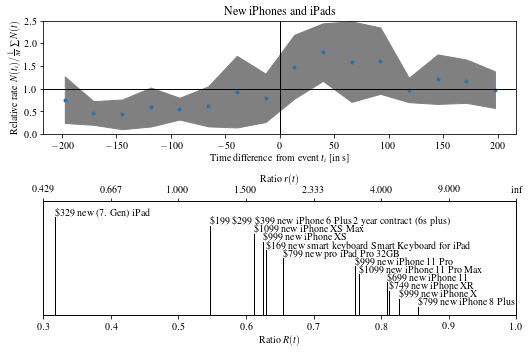

In [28]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7.5,5)

filtered = all_results_flat[[not pd.isna(a) and ('iphone' in a.lower() or 'ipad' in a.lower()) and ('neu' in a.lower()) 
                             for a in all_results_flat['metadata'] ]]


plt.rcParams["figure.figsize"] = (7.5,5)

fig,axs = plt.subplots(2)


draw_histogram(axs[0], 250*1000, filtered, drawannotations=axs[1], label='New iPhones and iPads (at sale price announcement)',
               title='New iPhones and iPads')

axs[0].set_ylim([0,2.5])
plt.tight_layout()
fig.savefig(folder+"res_lob41.pdf")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


keynote start& 2.17 $\pm$ 1.13 & 0.65 $\pm$ 0.13 \\


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


random $t$& 1.15 $\pm$ 0.67 & 0.50 $\pm$ 0.11 \\


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


all keywords& 1.17 $\pm$ 0.49 & 0.52 $\pm$ 0.10 \\


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


new product& 2.14 $\pm$ 1.56 & 0.62 $\pm$ 0.15 \\
new \textit{iPhone}/\textit{iPad}& 2.92 $\pm$ 1.72 & 0.69 $\pm$ 0.14 \\


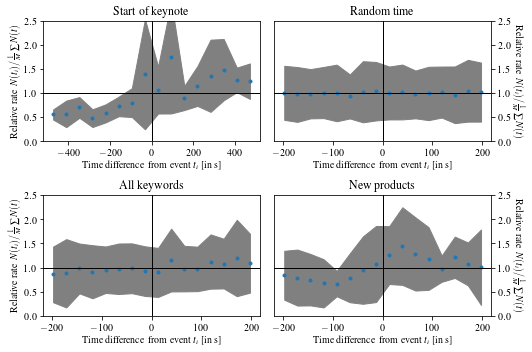

In [27]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7.5,5)

filte['numbins']=100
filte['range']['time'] = [9.5*3600*1000, 16.*3600*1000] 
fig,axs = plt.subplots(2,2)

draw_histogram(axs[0][0], 10*60*1000, all_results_flat[all_results_flat['src'] == 'kn_start'], fract='frac_of_total600',
              label='keynote start',title='Start of keynote')
draw_histogram(axs[0][1], 250*1000, all_results_flat[all_results_flat['src'] == 'random_kn'],
              label='random $t$',axright=True,title='Random time')
draw_histogram(axs[1][0], 250*1000, all_results_flat[(all_results_flat['src'] == 'keyword_ocr') | (all_results_flat['src'] == 'keyword_subs')],
              label='all keywords',title='All keywords')
filtered = all_results_flat[[not pd.isna(a) and ('neu' in a.lower()) 
                             for a in all_results_flat['metadata'] ]]
draw_histogram(axs[1][1], 250*1000, filtered,
              label='new product',axright=True,title='New products')

for axa in axs:
    for ax in axa:
        ax.set_ylim([0,2.5])

filtered2 = all_results_flat[[not pd.isna(a) and ('iphone' in a.lower() or 'ipad' in a.lower()) and ('neu' in a.lower()) 
                             for a in all_results_flat['metadata'] ]]
draw_histogram(None, 250*1000, filtered2,  label='new \\textit{iPhone}/\\textit{iPad}')
plt.tight_layout()
fig.savefig(folder+"res_lob40.pdf")
